# Question on CNNs

1.	Write the data-loader
2.	Use data augmentation techniques to increase the size of the training set.
3.	Train the CNN model (implementing early stopping to prevent overfitting is better)
4.  Plot loss values
5.  Show a few samples of the train and test set
6.	Evaluate the model on the test set and report the accuracy and loss.
7.  provide the labels of the test_set in a file labelled Submission.csv. Submission.cvs should have a column called labels which should contain the labels of all the images

In [1]:
#idx2numpy will be used to read the data 
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=ee1017023e4d2d1c9d0cd6930c49dfc4996c56d4596f02f69e069e6c32321886
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [2]:
!wget -O data.zip https://www.dropbox.com/s/by3l3l9xe4iiara/data%202.zip?dl=0

--2023-05-12 15:18:23--  https://www.dropbox.com/s/by3l3l9xe4iiara/data%202.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/by3l3l9xe4iiara/data%202.zip [following]
--2023-05-12 15:18:23--  https://www.dropbox.com/s/raw/by3l3l9xe4iiara/data%202.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b4633b6fe8cd163c63cdca80d.dl-eu.dropboxusercontent.com/cd/0/inline/B75Lm_Yhh2bT4MvsLLXRQmgi7JqTI3OsF-z-avs3uLf711UkEr9bqrhuRxaxMnTOKNALT58d_64Se1cHRebHC5le79bkvj6LtLEQuVEUpRGwqv4_GLExa2vzTjchYnI4_zV1-5hfraSX2Vkqrt5Sqp3uxJ2bXzF0mb4yML9PcEsiKQ/file# [following]
--2023-05-12 15:18:24--  https://uc4b4633b6fe8cd163c63cdca80d.dl-eu.dropboxusercontent.com/cd/0/inline/B75Lm_Yhh2bT4MvsLLXRQmgi7JqTI3OsF-z-avs3uLf711UkEr9bqrhuRxaxMnTOKNALT

In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/test-labels-idx1   
  inflating: __MACOSX/data/._test-labels-idx1  
  inflating: data/train-images-idx3  
  inflating: __MACOSX/data/._train-images-idx3  
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/train-labels-idx1  
  inflating: __MACOSX/data/._train-labels-idx1  
  inflating: data/test-images-idx3   
  inflating: __MACOSX/data/._test-images-idx3  


In [4]:
!ls data/

test-images-idx3  test-labels-idx1  train-images-idx3  train-labels-idx1


In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v2 as iio
from torchvision import models,transforms
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.batchnorm import BatchNorm1d
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import idx2numpy

In [6]:
#read images train
f_read_train = open('data/train-images-idx3', 'rb')
train_images = idx2numpy.convert_from_file(f_read_train)

In [7]:
#read images test
f_read_test = open('data/test-images-idx3', 'rb')
test_images = idx2numpy.convert_from_file(f_read_test)

In [8]:
#read labels train
f_read_train_labels = open('data/train-labels-idx1', 'rb')
train_labels = idx2numpy.convert_from_file(f_read_train_labels)

In [9]:
#read labels test
f_read_test_labels = open('data/test-labels-idx1', 'rb')
test_labels = idx2numpy.convert_from_file(f_read_test_labels)

S

In [10]:
# create datasets for train, val and test

# train dataset
class Dataset_Train(Dataset):
  # init
  def __init__(self, path1, path2, trans=None):
    self.path1 = path1
    self.path2 = path2
    f_read_train = open(path1, 'rb')
    self.imgList = idx2numpy.convert_from_file(f_read_train)
    split = 0.9*len(self.imgList)
    self.imgList = self.imgList[:int(split)]
    f_read_train_labels = open(path2, 'rb')
    self.lbList = idx2numpy.convert_from_file(f_read_train_labels)
    self.lbList = self.lbList[:int(split)]
    self.trans = trans

  # length of the dataset
  def __len__(self):
    return len(self.imgList)

  # given an index, it should return its contents
  def __getitem__(self, idx):
    """
    read the image and extract its label
    """
    img = self.imgList[idx]
    if self.trans:
      img = self.trans(img)
    fname = self.lbList[idx]
    return (img, fname)

# val dataset
class Dataset_Val(Dataset):
  # init
  def __init__(self, path1, path2,trans=None):
    self.path1 = path1
    self.path2 = path2
    f_read_train = open(path1, 'rb')
    self.imgList = idx2numpy.convert_from_file(f_read_train)
    split = 0.9*len(self.imgList)
    self.imgList = self.imgList[int(split):]
    f_read_train_labels = open(path2, 'rb')
    self.lbList = idx2numpy.convert_from_file(f_read_train_labels)
    self.lbList = self.lbList[int(split):]
    self.trans = trans

  # length of the dataset
  def __len__(self):
    return len(self.imgList)

  # given an index, it should return its contents
  def __getitem__(self, idx):
    """
    read the image and extract its label
    """

    img = self.imgList[idx]
    if self.trans:
      img = self.trans(img)
    fname = self.lbList[idx]
    return (img, fname)

# test dataset
class Dataset_Test(Dataset):
    # init
  def __init__(self, path1, path2,trans=None):
    self.path1 = path1
    self.path2 = path2
    f_read_test = open(path1, 'rb')
    self.imgList = idx2numpy.convert_from_file(f_read_test)
    f_read_test_labels = open(path2, 'rb')
    self.lbList = idx2numpy.convert_from_file(f_read_test_labels)
    self.trans = trans

  # length of the dataset
  def __len__(self):
    return len(self.imgList)

  # given an index, it should return its contents
  def __getitem__(self, idx):
    """
    read the image and extract its label
    """
    img = self.imgList[idx]
    if self.trans:
      img = self.trans(img)
    fname = self.lbList[idx]
    return (img, fname)

In [11]:
# make the splits for train and val
# get number of samples in train overall
train_samples = len(train_images)
print(f'Found {train_samples} images in train.')
train_split = int(train_samples * 0.9)
val_split = int(train_samples * 0.1)
print(f'{train_split} images for training.\n{val_split} images for validation.')

Found 60000 images in train.
54000 images for training.
6000 images for validation.


In [12]:
# create an instance of the dataset
dataset_train = Dataset_Train('data/train-images-idx3', 'data/train-labels-idx1', trans=transforms.ToTensor())
dataset_val = Dataset_Val('data/train-images-idx3', 'data/train-labels-idx1', trans=transforms.ToTensor())
dataset_test = Dataset_Test('data/test-images-idx3','data/test-labels-idx1', trans=transforms.ToTensor())

# extract an element from the dataset
dataset_train[0][0].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([1, 28, 28])

Text(0.5, 1.0, '0')

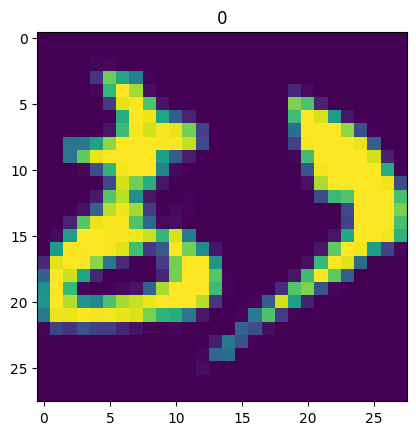

In [13]:
# visualize dataset
dataset_train[0][0].shape 
plt.imshow(dataset_train[100][0].permute(1,2,0))
plt.title(dataset_train[100][1])

In [14]:
# create dataloaders for train, val, and test
train_loader = DataLoader(dataset_train, batch_size = 64, shuffle = True) 
val_loader = DataLoader(dataset_val, batch_size = 64, shuffle = True) 
test_loader = DataLoader(dataset_test, batch_size = 64, shuffle = False) 

In [15]:
#moudel
class My_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # create layers
    self.conv1 = nn.Conv2d(1, 32, 3, 1, 1) 
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)

    self.layer1 = nn.Linear(64*7*7, 100)
    self.layer2 = nn.Linear(100, 100)

  # create forward function
  def forward(self,x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = F.max_pool2d(x,(2,2))
    # x --->(10,16,16)

    x = self.conv2(x)
    x = torch.relu(x)
    x = F.max_pool2d(x,(2,2))
    # x --->(50,8,8)

    x = x.view(-1,64*7*7)
    x = self.layer1(x)
    x = torch.relu(x)

    x = self.layer2(x)

    return x

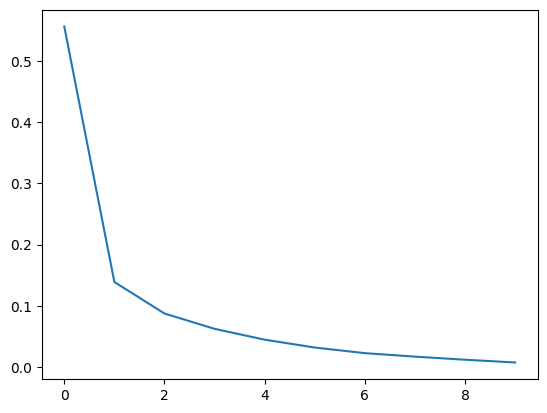

In [16]:
#train
# create training loop
device = torch.device("cuda:0")
net = My_CNN().to(device)
lr = 1e-2
mm = 0.9

opt = optim.SGD(net.parameters(), lr = lr, momentum = mm)
num_epochs = 10

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net(X)
    loss = F.cross_entropy(yhat, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))


plt.plot(ls)

In [17]:
#test
# CNN 
# create testing loop
correct = 0
total = 0
with torch.no_grad():
  for batch in val_loader: 
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    yhat = torch.argmax(logits, axis=1) 
    correct += torch.sum(y==yhat)
    total += y.shape[0]

print(f'We have {correct} images labelled correctly out of {total} images.')

We have 5889 images labelled correctly out of 6000 images.


In [18]:
print(f"accuracy= {correct/total * 100}")

accuracy= 98.14999389648438


In [19]:
# augmentation with net2

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
])

# create an instance of the dataset
dataset_train = Dataset_Train('data/train-images-idx3', 'data/train-labels-idx1', trans=trans)
dataset_val = Dataset_Val('data/train-images-idx3', 'data/train-labels-idx1', trans=trans)
dataset_test = Dataset_Test('data/test-images-idx3','data/test-labels-idx1', trans=transforms.ToTensor())


In [20]:
# create dataloaders for train, val and test
train_loader = DataLoader(dataset_train, batch_size = 64, shuffle = True) 
val_loader = DataLoader(dataset_val, batch_size = 64, shuffle = True) 
test_loader = DataLoader(dataset_test, batch_size = 64, shuffle = False) 

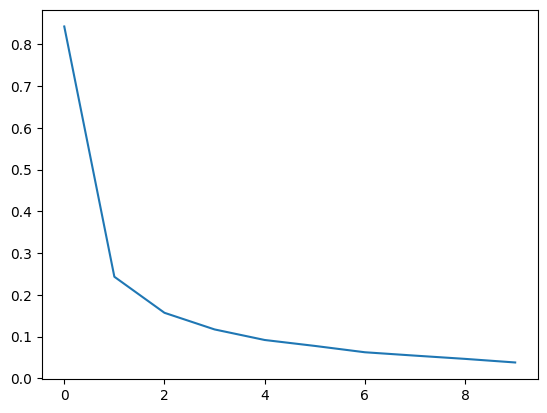

In [21]:
#train
# create training loop
device = torch.device("cuda:0")
net2 = My_CNN().to(device)
lr = 1e-2
mm = 0.9

opt = optim.SGD(net2.parameters(), lr = lr, momentum = mm)
num_epochs = 10

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net2(X)
    loss = F.cross_entropy(yhat, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))


plt.plot(ls)

In [22]:
#test
# CNN 
# create testing loop
correct = 0
total = 0
with torch.no_grad():
  for batch in val_loader: 
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net2(X)
    yhat = torch.argmax(logits, axis=1) 
    correct += torch.sum(y==yhat)
    total += y.shape[0]

print(f'We have {correct} images labelled correctly out of {total} images.')

We have 5848 images labelled correctly out of 6000 images.


In [23]:
print(f"accuracy= {correct/total * 100}")

accuracy= 97.46666717529297


In [24]:
# based on the above accuracy, net is better than net2

In [25]:
# creating labels list to add in submission file
test_lbls = []

with torch.no_grad():
  for batch in test_loader: 
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    yhat = torch.argmax(logits, axis=1)
    for lbl in yhat:
      test_lbls.append(int(lbl.cpu()))



In [26]:
test_lbls

[2,
 9,
 3,
 8,
 3,
 3,
 8,
 3,
 2,
 5,
 6,
 3,
 3,
 3,
 1,
 5,
 4,
 8,
 6,
 3,
 7,
 5,
 7,
 5,
 7,
 0,
 3,
 5,
 4,
 4,
 6,
 8,
 5,
 9,
 5,
 6,
 6,
 3,
 0,
 6,
 4,
 7,
 8,
 1,
 1,
 6,
 9,
 0,
 0,
 0,
 1,
 0,
 4,
 8,
 4,
 1,
 3,
 3,
 3,
 4,
 6,
 4,
 9,
 3,
 6,
 5,
 3,
 4,
 6,
 2,
 5,
 9,
 9,
 7,
 3,
 2,
 3,
 7,
 6,
 3,
 4,
 1,
 1,
 5,
 9,
 6,
 5,
 1,
 0,
 1,
 3,
 7,
 1,
 6,
 7,
 3,
 6,
 5,
 0,
 2,
 0,
 8,
 8,
 2,
 3,
 5,
 9,
 1,
 0,
 8,
 5,
 2,
 0,
 0,
 6,
 5,
 2,
 0,
 0,
 9,
 3,
 6,
 9,
 5,
 6,
 2,
 0,
 7,
 6,
 2,
 9,
 0,
 4,
 1,
 3,
 4,
 6,
 9,
 9,
 5,
 8,
 4,
 5,
 9,
 6,
 8,
 2,
 4,
 7,
 3,
 5,
 1,
 8,
 5,
 8,
 6,
 3,
 2,
 7,
 6,
 2,
 5,
 6,
 7,
 5,
 2,
 8,
 0,
 6,
 6,
 4,
 1,
 9,
 5,
 8,
 6,
 2,
 6,
 8,
 7,
 8,
 4,
 0,
 6,
 5,
 7,
 2,
 6,
 2,
 1,
 8,
 9,
 0,
 7,
 4,
 3,
 0,
 3,
 6,
 3,
 1,
 5,
 5,
 0,
 8,
 8,
 5,
 8,
 2,
 2,
 3,
 2,
 7,
 5,
 7,
 5,
 4,
 5,
 4,
 7,
 3,
 3,
 7,
 5,
 8,
 9,
 0,
 7,
 5,
 0,
 1,
 6,
 6,
 3,
 0,
 9,
 8,
 4,
 9,
 0,
 7,
 0,
 3,
 0,
 1,
 6,
 8,
 3,
 7,
 6,


In [27]:
# now we add labels of test



df = pd.DataFrame(data={
    'labels': test_lbls,
})

df.head()

,labels
0,2
1,9
2,3
3,8
4,3


In [28]:
# we save submission file
df.to_csv("submission.csv")